# Práctica 3 - Ejercicio 1

Asignatura: Programación para la Inteligencia Artificial

Alumno: Francisco Javier Pérez Cazorla

Típicamente el Aprendizjae Profundo se utiliza en problemas supervisados (conocemos la entrada y la salida para los datos de entrenamiento, validación y test). Este planteamiento tiene el problema de requerir que los datos hayan sido previamente etiquetados. Sin embargo, hay modelos neuronales que no tienen esta restricción.

Un Autocodificador (*Autoencoder*) es una red neuronal que se entrena para aprender la función identidad. Típicamente se puede dividir en dos secciones simétricas: una primera parte que codifica progresivamente la entrada a un espacio de menos dimensiones (denominado espacio latente) y una segunda parte que decodifica de vuelta al espacio de dimensiones original.

$x = d_{\theta_{1}}(e_{\theta_{2}}(x))$

Como aprende la función identidad, no requiere etiquetado para su entrenamiento.

Un Autocodificador con eliminación de ruido (*Denoising Autoencoder*) es una red neuronal que se entrena para eliminar el ruido de unos datos de entrada.

$x = d_{\theta_{1}}(e_{\theta_{2}}(\hat{x}))$

El objetivo de esta práctica es definir y entrenar un Autocodificar con eliminación de ruido capaz de lidiar con ruido gaussiano de media $\mu=0$ y desviación típica $\sigma=0.2$ para el conjunto de datos Fashion-MNIST (https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html). El autocodificador se compondrá de neuronas lineales y el espacio latente será de 8 dimensiones.

Para evaluar la efectividad del modelo entrenado se utilizarán todos los ejemplos del conjunto de test y el error absoluto. Se incluirá el código necesario para mostrar un ejemplo cualquiera del conjunto de test con ruido, sin ruido y el resultado del autocodificador.

Una vez entrenado, se mostrará la relación entre las componentes de las codificaciones del conjunto de test con la clase asociada a dichas codificaciones. Se mostrarán gráficas 2D cuyos ejes muestren los valores de 2 componentes y muestren la clase como el color de cada punto.

### 1. Inicialización del Entorno
Importamos las librerías necesarias (`torch`, `torchvision`, `matplotlib`) y configuramos el estilo visual de las gráficas (`dark_background`) para asegurar una visualización clara y distintiva.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
from sklearn.manifold import TSNE

# Configuración de estilo visual (Dark Theme)
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.color'] = '#ffffff'

### 2. Configuración del Sistema
Definimos un diccionario `SYS_CONFIG`. Mantenemos `EPOCHS` alto (150) y `PATIENCE` (10) para el Early Stopping.

In [2]:
# --- BLOQUE DE CONFIGURACIÓN DEL SISTEMA ---
SYS_CONFIG = {
    'BATCH_SIZE': 128,            # Tamaño del lote
    'LEARNING_RATE': 1e-3,        # Tasa de aprendizaje
    'EPOCHS': 180,                # Épocas máximas
    'PATIENCE': 10,               # Paciencia para Early Stopping
    'NOISE_FACTOR': 0.2,          # Factor de ruido (Sigma)
    'LATENT_DIM': 8,              # Dimensión del espacio latente
    'SEED': 42
}

# Selección de dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SYS_CONFIG['SEED'])

print(f"╔{'═'*40}╗")
print(f"║ SISTEMA INICIALIZADO (Modo GPU Pro)    ║")
print(f"╠{'═'*40}╣")
print(f"║ Dispositivo     : {str(DEVICE).upper():<20} ║")
print(f"║ Épocas Máximas  : {SYS_CONFIG['EPOCHS']:<20} ║")
print(f"║ Paciencia (Stop): {SYS_CONFIG['PATIENCE']:<20} ║")
print(f"╚{'═'*40}╝")

╔════════════════════════════════════════╗
║ SISTEMA INICIALIZADO (Modo GPU Pro)    ║
╠════════════════════════════════════════╣
║ Dispositivo     : CUDA                 ║
║ Épocas Máximas  : 180                  ║
║ Paciencia (Stop): 10                   ║
╚════════════════════════════════════════╝


### 3. Carga de Datos Rigurosa (Train / Val / Test)
Para ser metodológicamente estrictos:
1.  Descargamos el conjunto de Entrenamiento (60.000 imágenes).
2.  Lo dividimos manualmente: **50.000 para Train** y **10.000 para Validation** (usado para el Early Stopping).
3.  Descargamos el conjunto de Test (10.000 imágenes) y lo reservamos **exclusivamente** para la auditoría final.
Usamos `FastGPULoader` modificado para aceptar tensores y cargar todo en VRAM.

In [3]:
class FastGPULoader:
    """
    Cargador de datos de alto rendimiento. Recibe tensores directamente
    y los mueve a la GPU al inicializarse.
    """
    def __init__(self, data_tensor, target_tensor, batch_size, shuffle=True):
        print(f"[GPU LOADER] Cargando {len(data_tensor)} muestras en VRAM...")
        # Normalización manual y envío a GPU
        self.data = data_tensor.unsqueeze(1).float().div(255.0).to(DEVICE)
        self.targets = target_tensor.to(DEVICE)

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = self.data.size(0)

    def __iter__(self):
        if self.shuffle:
            idx = torch.randperm(self.size, device=DEVICE)
            self.data = self.data[idx]
            self.targets = self.targets[idx]

        for i in range(0, self.size, self.batch_size):
            yield self.data[i:i+self.batch_size], self.targets[i:i+self.batch_size]

    def __len__(self):
        return (self.size + self.batch_size - 1) // self.batch_size

# 1. Descarga de datos crudos
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# 2. Splitting manual (50k Train / 10k Val)
# Accedemos a los tensores internos .data y .targets
train_data = full_train_dataset.data[:50000]
train_targets = full_train_dataset.targets[:50000]

val_data = full_train_dataset.data[50000:]
val_targets = full_train_dataset.targets[50000:]

test_data = full_test_dataset.data
test_targets = full_test_dataset.targets

# 3. Inicialización de cargadores en GPU
train_loader = FastGPULoader(train_data, train_targets, SYS_CONFIG['BATCH_SIZE'], shuffle=True)
val_loader = FastGPULoader(val_data, val_targets, SYS_CONFIG['BATCH_SIZE'], shuffle=False)
test_loader = FastGPULoader(test_data, test_targets, SYS_CONFIG['BATCH_SIZE'], shuffle=False)

print(f"\nDistribución: Train={len(train_data)} | Val={len(val_data)} | Test={len(test_data)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]


[GPU LOADER] Cargando 50000 muestras en VRAM...
[GPU LOADER] Cargando 10000 muestras en VRAM...
[GPU LOADER] Cargando 10000 muestras en VRAM...

Distribución: Train=50000 | Val=10000 | Test=10000


### 4. Modelo Autoencoder (SignalCompressor)
Definimos la arquitectura del Autoencoder con capas densas.

In [4]:
class SignalCompressor(nn.Module):
    def __init__(self, latent_dim):
        super(SignalCompressor, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        latent = self.encoder(x_flat)
        reconstructed = self.decoder(latent)
        return reconstructed.view(x.size(0), 1, 28, 28), latent

# Instanciación
model = SignalCompressor(latent_dim=SYS_CONFIG['LATENT_DIM']).to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=SYS_CONFIG['LEARNING_RATE'])

### 5. Lógica de Entrenamiento con Early Stopping
Usamos `train_loader` para aprender y `val_loader` para monitorizar el Early Stopping. El conjunto de Test ni se toca aquí.

In [5]:
class EarlyStopping:
    """Detiene el entrenamiento si la loss no mejora tras 'patience' épocas."""
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

class TrainingEngine:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

        self.train_loss_history = []
        self.val_loss_history = []
        self.auxiliary_metrics_log = []

    def _add_noise(self, img, noise_factor):
        noise = torch.randn_like(img) * noise_factor
        return torch.clamp(img + noise, 0., 1.)

    def train(self, train_loader, val_loader, epochs, noise_factor, patience):
        print(f"\n>>> INICIANDO ENTRENAMIENTO INTELIGENTE ({epochs} Épocas Máx)...")

        stopper = EarlyStopping(patience=patience)
        pbar = tqdm(range(epochs), desc="Progreso", unit="epoch")

        for epoch in pbar:
            # --- Training ---
            batch_losses = []

            for imgs, _ in train_loader:
                noisy_imgs = self._add_noise(imgs, noise_factor)
                output, _ = self.model(noisy_imgs)
                loss = self.criterion(output, imgs)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss.item())

            self.train_loss_history.append(np.mean(batch_losses))

            # --- Validation (Usamos val_loader) ---
            val_batch_losses = []

            with torch.no_grad():
                for imgs, _ in val_loader:
                    noisy_imgs = self._add_noise(imgs, noise_factor)
                    output, _ = self.model(noisy_imgs)
                    val_loss = self.criterion(output, imgs)
                    val_batch_losses.append(val_loss.item())

            avg_val_loss = np.mean(val_batch_losses)
            self.val_loss_history.append(avg_val_loss)
            self.auxiliary_metrics_log.append(0.0)

            # Chequeo Early Stopping
            stopper(avg_val_loss, self.model)

            pbar.set_postfix({
                'Train': f"{self.train_loss_history[-1]:.4f}",
                'Val': f"{avg_val_loss:.4f}",
                'Patience': f"{stopper.counter}/{patience}"
            })

            if stopper.early_stop:
                print(f"\n[!] Early Stopping activado en época {epoch+1}. Recuperando mejor modelo...")
                self.model.load_state_dict(stopper.best_model_state)
                break

        return self.model, self.train_loss_history, self.val_loss_history, self.auxiliary_metrics_log

# Ejecución
trainer = TrainingEngine(model, optimizer, criterion)
trained_model, loss_t, loss_v, _ = trainer.train(
    train_loader, val_loader,
    SYS_CONFIG['EPOCHS'],
    SYS_CONFIG['NOISE_FACTOR'],
    SYS_CONFIG['PATIENCE']
)


>>> INICIANDO ENTRENAMIENTO INTELIGENTE (180 Épocas Máx)...


Progreso:  96%|█████████▌| 173/180 [03:07<00:07,  1.09s/epoch, Train=0.0552, Val=0.0568, Patience=10/10]


[!] Early Stopping activado en época 174. Recuperando mejor modelo...


### 6. Visualización y Auditoría Final (Sobre Test Set)
Ahora sí, usamos `test_loader` para la evaluación final. Este conjunto de datos es "virgen" para el modelo, por lo que la métrica de error será totalmente honesta.

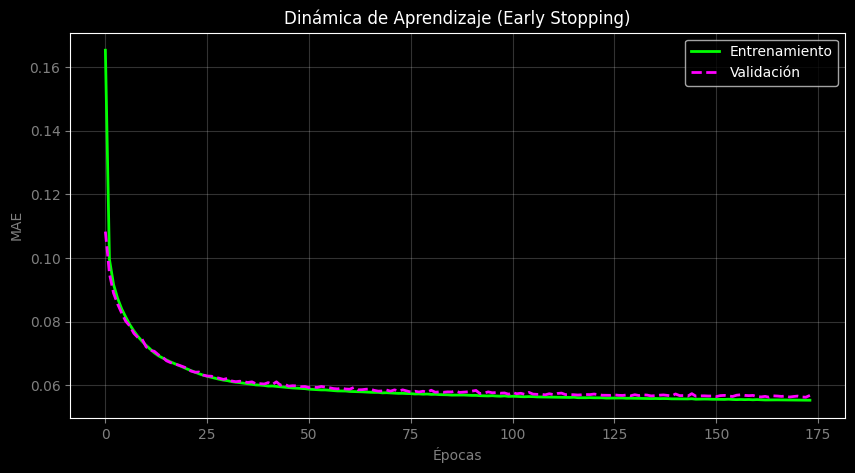


[AUDITORÍA FINAL] MAE en TEST SET (Datos nunca vistos): 0.056602


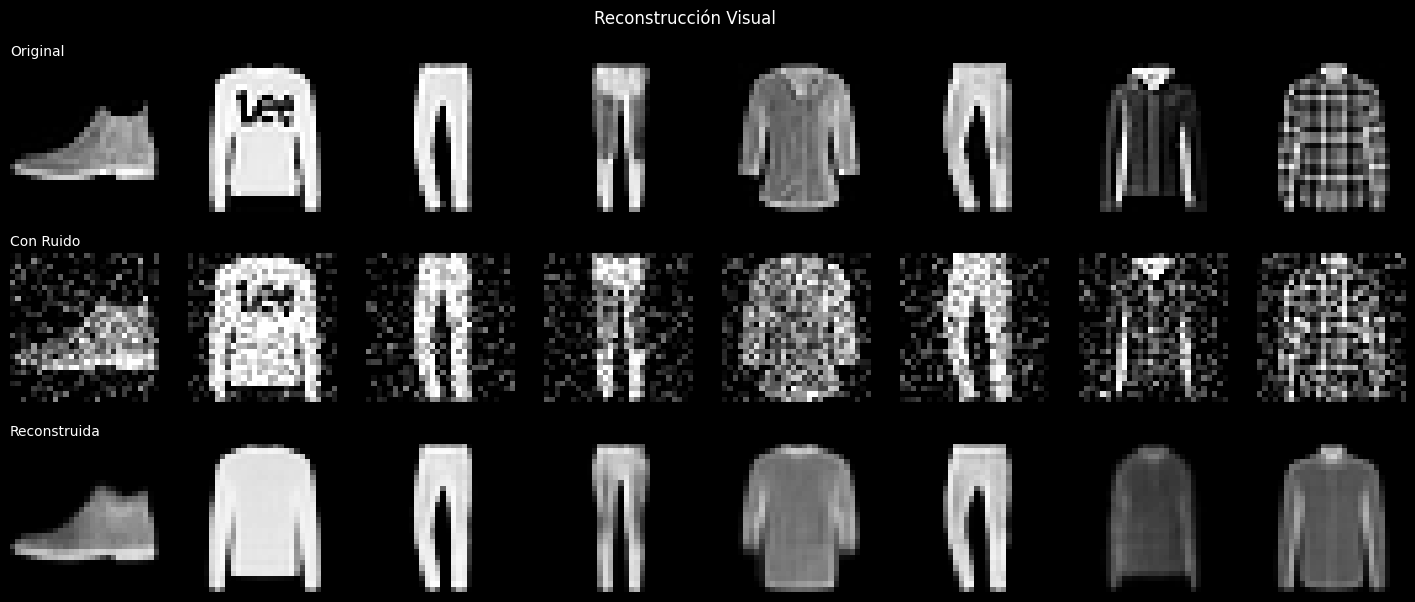

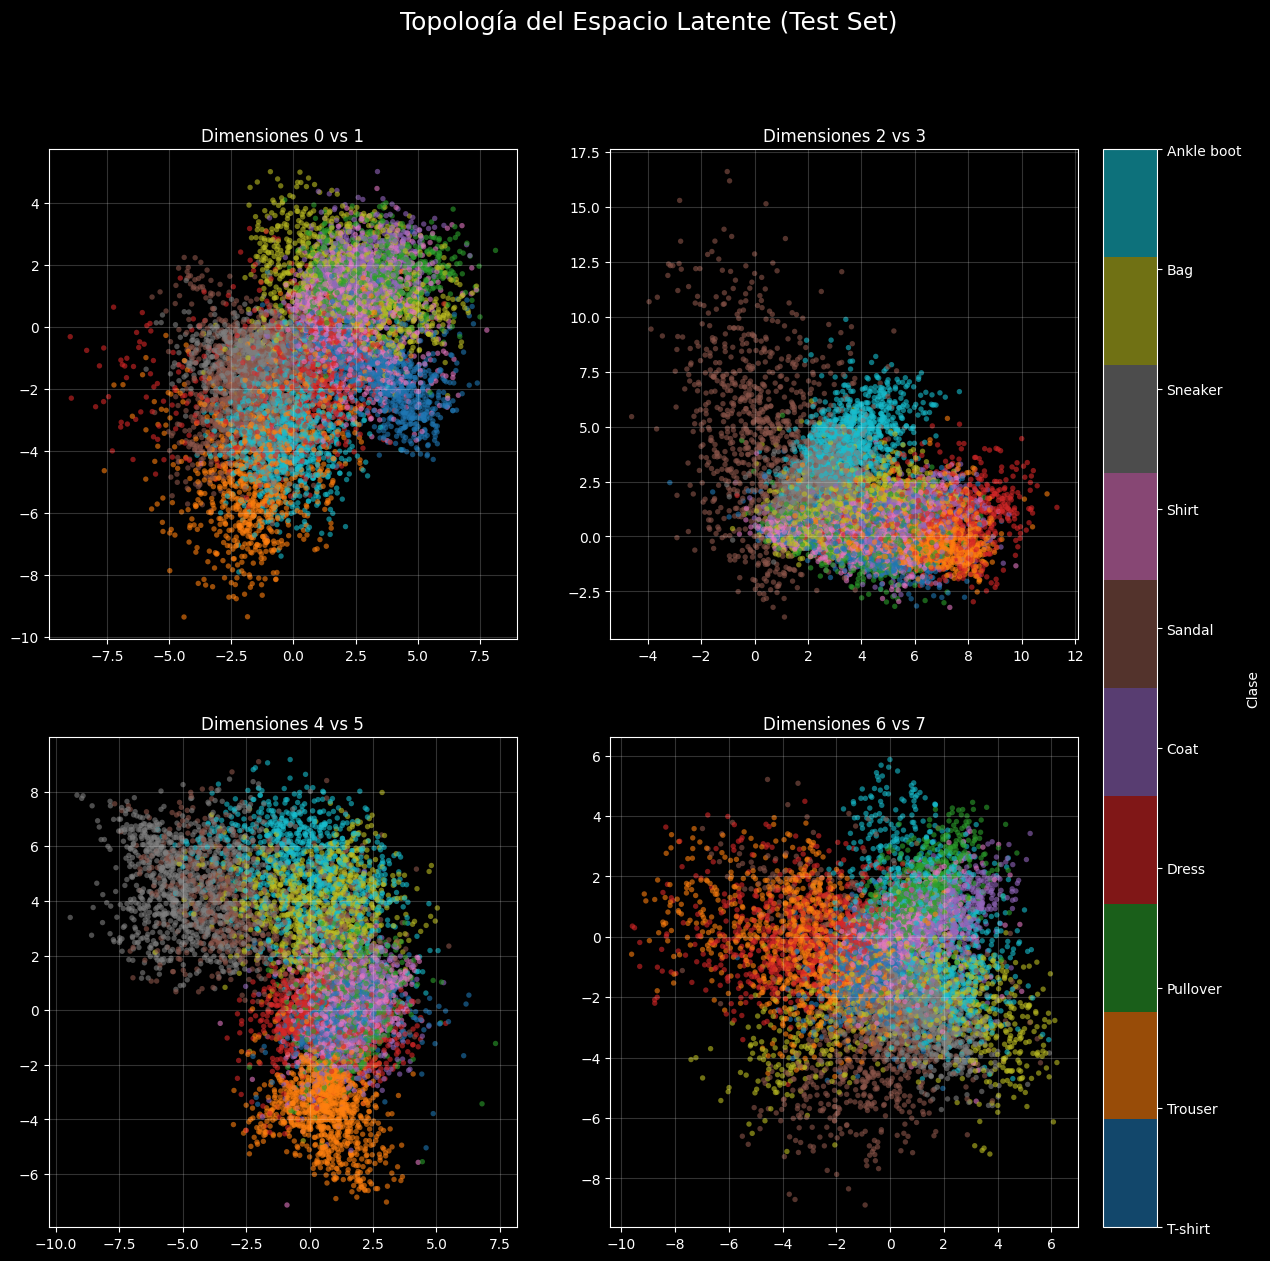


[INFO] Calculando proyección t-SNE para DAE...


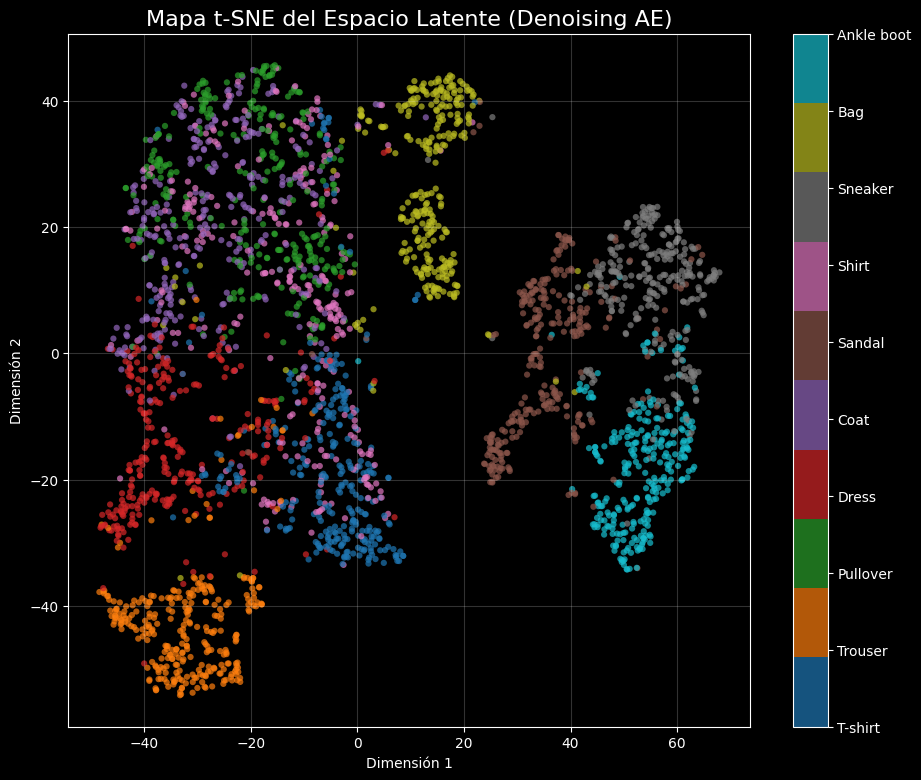

In [9]:
class VisualAuditor:
    def __init__(self, model, noise_factor):
        self.model = model
        self.noise_factor = noise_factor
        self.classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def _add_noise(self, tensor):
        noise = torch.randn_like(tensor) * self.noise_factor
        return torch.clamp(tensor + noise, 0., 1.)

    def plot_learning_curves(self, train_loss, val_loss):
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label='Entrenamiento', color='#00ff00', linewidth=2)
        plt.plot(val_loss, label='Validación', color='#ff00ff', linestyle='--', linewidth=2)
        plt.title('Dinámica de Aprendizaje (Early Stopping)', color='white')
        plt.xlabel('Épocas', color='gray')
        plt.ylabel('MAE', color='gray')
        plt.legend()
        plt.tick_params(colors='gray')
        plt.show()

    def plot_tsne_map(self, loader):
        """ Proyección t-SNE (Denoising AE) """
        print("\n[INFO] Calculando proyección t-SNE para DAE...")

        latents, labels = [], []
        limit = 3000
        count = 0

        with torch.no_grad():
            for imgs, lbls in loader:
                if count >= limit: break

                # El modelo ya devuelve (recon, latent)
                _, z = self.model(imgs)

                latents.append(z.cpu().numpy())
                labels.append(lbls.cpu().numpy())
                count += imgs.size(0)

        latents = np.concatenate(latents, axis=0)[:limit]
        labels = np.concatenate(labels, axis=0)[:limit]

        # Ejecutar t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        latents_2d = tsne.fit_transform(latents)

        # Visualizar
        plt.figure(figsize=(11, 9))
        cmap = plt.get_cmap('tab10', 10)
        scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1],
                              c=labels, cmap=cmap, alpha=0.7, s=20, edgecolors='none')

        cbar = plt.colorbar(scatter, ticks=range(10))
        cbar.set_ticklabels(self.classes)

        plt.title("Mapa t-SNE del Espacio Latente (Denoising AE)", fontsize=16)
        plt.xlabel("Dimensión 1")
        plt.ylabel("Dimensión 2")
        plt.show()

    def evaluate_and_plot(self, loader, metric_fn):
        total_mae = 0.0
        sample_data = None

        with torch.no_grad():
            for imgs, _ in loader:
                noisy = self._add_noise(imgs)

                # Desempaquetamos la tupla (recon, latent) ---
                recon, _ = self.model(noisy)

                total_mae += metric_fn(recon, imgs).item()
                if sample_data is None:
                    sample_data = (imgs.cpu(), noisy.cpu(), recon.cpu())

        final_mae = total_mae / len(loader)
        print(f"\n[AUDITORÍA FINAL] MAE en TEST SET (Datos nunca vistos): {final_mae:.6f}")
        self._plot_grid(sample_data)

    def _plot_grid(self, data, n=8):
        orig, noisy, recon = data
        fig, axes = plt.subplots(3, n, figsize=(18, 7))
        rows = ['Original', 'Con Ruido', 'Reconstruida']

        for i in range(n):
            axes[0, i].imshow(orig[i].squeeze(), cmap='gray', vmin=0, vmax=1)
            axes[0, i].axis('off')
            axes[1, i].imshow(noisy[i].squeeze(), cmap='gray', vmin=0, vmax=1)
            axes[1, i].axis('off')
            axes[2, i].imshow(recon[i].squeeze(), cmap='gray', vmin=0, vmax=1)
            axes[2, i].axis('off')
            if i == 0:
                for r, row in enumerate(rows):
                    axes[r, 0].set_title(row, loc='left', color='white', fontsize=10)
        plt.suptitle(f"Reconstrucción Visual", color='white', y=0.95)
        plt.show()

    def plot_latent_space(self, loader):
        """ Topología por pares (Usando el return del forward) """
        latents, labels = [], []
        with torch.no_grad():
            for imgs, lbls in loader:
                # Usamos el forward directo: nos da el latente en la segunda posición
                _, lat = self.model(imgs)

                latents.append(lat.cpu().numpy())
                labels.append(lbls.cpu().numpy())

        latents = np.concatenate(latents, axis=0)
        labels = np.concatenate(labels, axis=0)

        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        axes = axes.flatten()
        cmap = plt.get_cmap('tab10', 10)
        for idx in range(4):
            ax = axes[idx]
            dim_x, dim_y = idx * 2, (idx * 2) + 1
            scatter = ax.scatter(latents[:, dim_x], latents[:, dim_y],
                                 c=labels, cmap=cmap, alpha=0.6, s=15, edgecolors='none')
            ax.set_title(f'Dimensiones {dim_x} vs {dim_y}', color='white')
        cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), pad=0.02)
        cbar.set_label('Clase', color='white')
        cbar.set_ticks(range(10))
        cbar.set_ticklabels(self.classes) # Para que se vean los nombres
        cbar.ax.tick_params(labelcolor='white')
        plt.suptitle("Topología del Espacio Latente (Test Set)", color='white', fontsize=18)
        plt.show()

# Ejecutar visualización
viz = VisualAuditor(trained_model, SYS_CONFIG['NOISE_FACTOR'])
viz.plot_learning_curves(loss_t, loss_v)
# Usamos test_loader para la evaluación final
viz.evaluate_and_plot(test_loader, criterion)
viz.plot_latent_space(test_loader)
# Generar el mapa t-SNE
viz.plot_tsne_map(test_loader)